In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
from tqdm import tqdm

from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

In [17]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 80
# BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUMBER_OF_NEURONS = 512
REGULARIZATION_LAMBDA = 0.1

In [20]:
# UTILS
def sigmoid(x):
    return np.multiply(0.5, (1 + np.tanh(np.multiply(0.5, x))))


def relu(x):
    return x.clip(min=0)


def sigmoid_derivative(x):
    return np.multiply(x, (1 - x))


def relu_derivative(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x


def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]


def split_data(dataset, train_size=0.8):
    if isinstance(dataset, pd.core.frame.DataFrame):
        dataset = dataset.sample(frac=1)
    elif isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Pandas DataFrame required.')

    size = dataset.shape[0]
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]


def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array required.')

    return np.array_split(dataset, k)


def get_under_sample_dataset(dataset, train_and_validation):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, fraud_indices.shape[0], replace=False))
    under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
    return dataset.iloc[under_sample_indices, :].sample(frac=1)

def get_radnom_normal_indices(dataset,train_and_validation):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, fraud_indices.shape[0], replace=False))
    return dataset.iloc[random_normal_indices, :].sample(frac=1)

def plot_loss(epochs, training_history, validation_history):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, training_history, label='train_loss')
    ax.plot(x_axis, validation_history, label='val_loss')
    ax.legend()
    plt.ylabel('MSE')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    plt.show()


def plot_confusion_matrix(model, x, y):
    predicted = np.round(model.predict(x)).reshape(-1, )
    actual = y.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns=['actual 1', 'actual 0'],
                                    index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print('\n')
    print(confusion_matrix)
    
    
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    


In [22]:
# Read CSV
#dataset = pd.read_csv(DATASET_NAME)
dataset = pd.read_csv("creditcard.csv")

assert not dataset.isnull().values.any()
dataset = dataset.drop(['Time','Amount'],axis=1)

NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'

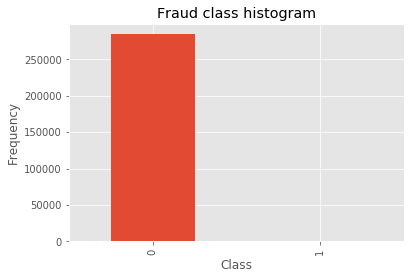

0    284315
1       492
Name: Class, dtype: int64

In [23]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [24]:
# Split dataset on train_and_validation dataset and test dataset
train_and_validation, test = split_data(dataset, train_size=0.8)

# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

In [25]:
# Create balanced, under sample train and validation dataset 
under_sample_dataset = get_under_sample_dataset(dataset, train_and_validation)


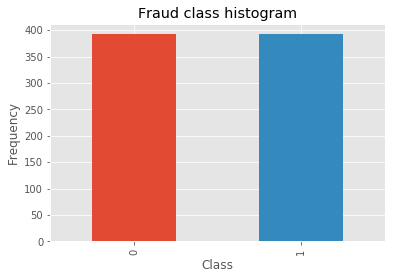

0    392
1    392
Name: Class, dtype: int64

In [26]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [27]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [29]:
class Layer:
    def __init__(self, input_dim, neurons_number, learning_rate, activation):
        self.activation = activation
        self.learning_rate = learning_rate

        self.output_layer = True

        self.input = np.asmatrix(np.zeros((input_dim + 1, 1)))
        self.output = np.asmatrix(np.zeros((neurons_number, 1)))
        self.weights = np.asmatrix(np.random.uniform(low=-2/(input_dim**0.5), high=2/(input_dim**0.5), size=(input_dim + 1, neurons_number)))
        self.deltas = np.asmatrix(np.zeros((neurons_number, 1)))
        self.cumulative_gradient = np.asmatrix(np.zeros((input_dim + 1, neurons_number)))

    def _activate(self, x):
        if self.activation == 'sigmoid':
            return sigmoid(x)
        elif self.activation == 'relu':
            return relu(x)

    def _get_gradient(self):
        return np.matmul(self.input, self.deltas.transpose())

    def forward_step(self, input_data):
        self.input = np.concatenate([[[1]], input_data])  # Add bias
        self.output = self._activate(np.matmul(self.weights.transpose(), self.input))
        return self.output

    def backward_step(self, next_weights=None, next_deltas=None, output_delta=None):
        if self.output_layer:
            self.deltas = output_delta
        else:
            derivative_of_activation = self.get_activation_derivative(self.output)
            self.deltas = np.multiply(np.matmul(np.delete(next_weights, 0, 0), next_deltas),
                                      derivative_of_activation)  # Exclude bias row from weights

        self.cumulative_gradient = self.cumulative_gradient + self._get_gradient()

    def get_activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return sigmoid_derivative(x)
        elif self.activation == 'relu':
            return relu_derivative(x)

    def get_deltas(self):
        return self.deltas

    def get_weights(self):
        return self.weights


class NeuralNetwork:
    def __init__(self, learning_rate, batch_size=50, epochs=20, loss='mse', regular_lambda=0.1):
        self.layers = []
        self.lerning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.loss = loss
        self.regular_lambda = regular_lambda

        self.training_history = []
        self.validation_history = []

    def _global_forward_step(self, x_train_batch):
        y_predicted_batch = []
        for x_train_record in x_train_batch:
            x_train_record = x_train_record.reshape((-1, 1))
            for layer in self.layers:
                x_train_record = layer.forward_step(x_train_record)
            y_predicted_batch.append(x_train_record)

        return np.concatenate(y_predicted_batch)

    def _global_backward_step(self, y_predicted_record, y_train_record):

        output_delta = self._count_output_delta(y_predicted_record, y_train_record)

        output_layer = self.layers[-1]
        output_layer.backward_step(output_delta=output_delta)

        next_deltas = output_layer.get_deltas()
        next_weights = output_layer.get_weights()

        for layer in reversed(self.layers[:-1]):
            layer.backward_step(next_weights=next_weights, next_deltas=next_deltas)

    def _count_output_delta(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.sum(np.multiply((y_predicted - y_actual), self.layers[-1].get_activation_derivative(y_predicted)), axis=0)

    def _save_loss(self, x_tr, y_tr, x_val, y_val):
        y_predicted_train = self._global_forward_step(x_tr)
        train_loss = self._count_loss(y_predicted_train, y_tr)
        self.training_history.append(train_loss)

        if x_val is not None and y_val is not None:
            y_predicted_validation = self._global_forward_step(x_val)
            validation_loss = self._count_loss(y_predicted_validation, y_val)
            self.validation_history.append(validation_loss)

        print("Loss: ", train_loss)
        print("Accuracy: ", accuracy_score(y_tr, np.round(y_predicted_train)))

    def _count_loss(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.average(np.square(y_actual - y_predicted))

    def add_layer(self, input_dim, neurons_number, activation='sigmoid'):
        layer = Layer(input_dim, neurons_number, learning_rate=self.lerning_rate, activation=activation)
        if self.layers:
            self.layers[-1].output_layer = False
        self.layers.append(layer)

    def fit(self, x_tr, y_tr, x_val=None, y_val=None):
        for i in range(self.epochs):
            for idx in range(0, x_tr.shape[0], self.batch_size):
                x_train_batch = x_tr[idx:idx + self.batch_size]
                y_train_batch = y_tr[idx:idx + self.batch_size]

                for n, x_train_record in enumerate(x_train_batch):
                    x_train_record = x_train_record.reshape(1, -1)
                    y_predicted_record = self._global_forward_step(x_train_record)
                    self._global_backward_step(y_predicted_record, y_train_batch[n])

                for lyr in self.layers:
                    gradient = lyr.cumulative_gradient / x_train_batch.shape[0] + self.regular_lambda * lyr.weights
                    lyr.weights = lyr.weights - np.multiply(self.lerning_rate, gradient)
                    lyr.BIG_DELTAS = np.asmatrix(np.zeros(lyr.cumulative_gradient.shape))
            self._save_loss(x_tr, y_tr, x_val, y_val)

    def predict(self, x):
        return self._global_forward_step(x)

    def evaluate(self, x, y):
        y_predicted = self._global_forward_step(x)
        loss = self._count_loss(y_predicted, y)

        print("Loss: ", loss)
        print("Accuracy: ", accuracy_score(y, np.round(y_predicted)))

Loss: 

0.249297529138

Accuracy: 

0.5830670926517572

Loss: 

0.24464035844

Accuracy: 

0.5878594249201278

Loss: 

0.238450399678

Accuracy: 

0.5910543130990416

Loss: 

0.231532615841

Accuracy: 

0.597444089456869

Loss: 

0.22446403385

Accuracy: 

0.6022364217252396

Loss: 

0.217287863845

Accuracy: 

0.6086261980830671

Loss: 

0.209667726729

Accuracy: 

0.6134185303514377

Loss: 

0.201151796731

Accuracy: 

0.6277955271565495

Loss: 

0.191647323518

Accuracy: 

0.6357827476038339

Loss: 

0.18264818342

Accuracy: 

0.645367412140575

Loss: 

0.17612198034

Accuracy: 

0.65814696485623

Loss: 

0.172608610444

Accuracy: 

0.6597444089456869

Loss: 

0.17068606898

Accuracy: 

0.6677316293929713

Loss: 

0.168797688758

Accuracy: 

0.6725239616613419

Loss: 

0.166448516691

Accuracy: 

0.6853035143769968

Loss: 

0.163562693532

Accuracy: 

0.6980830670926518

Loss: 

0.160142015157

Accuracy: 

0.707667731629393

Loss: 

0.156209788667

Accuracy: 

0.7204472843450479

Loss: 

0.151802802933

Accuracy: 

0.7364217252396166

Loss: 

0.146969216289

Accuracy: 

0.7603833865814696

Loss: 

0.141767137712

Accuracy: 

0.7891373801916933

Loss: 

0.136263317286

Accuracy: 

0.8035143769968051

Loss: 

0.130531557769

Accuracy: 

0.8226837060702875

Loss: 

0.124650814341

Accuracy: 

0.8450479233226837

Loss: 

0.118703207928

Accuracy: 

0.8642172523961661

Loss: 

0.112771921449

Accuracy: 

0.8801916932907349

Loss: 

0.106939113822

Accuracy: 

0.8881789137380192

Loss: 

0.101283903315

Accuracy: 

0.9009584664536742

Loss: 

0.0958803298899

Accuracy: 

0.902555910543131

Loss: 

0.0907953842378

Accuracy: 

0.9057507987220448

Loss: 

0.086087109084

Accuracy: 

0.9073482428115016

Loss: 

0.0818029508252

Accuracy: 

0.9137380191693291

Loss: 

0.0779785456779

Accuracy: 

0.9185303514376997

Loss: 

0.0746370603948

Accuracy: 

0.9217252396166135

Loss: 

0.071789188605

Accuracy: 

0.9217252396166135

Loss: 

0.0694336580303

Accuracy: 

0.9201277955271565

Loss: 

0.0675580703893

Accuracy: 

0.9233226837060703

Loss: 

0.0661400004029

Accuracy: 

0.9185303514376997

Loss: 

0.0651483599165

Accuracy: 

0.9201277955271565

Loss: 

0.0645452274299

Accuracy: 

0.9169329073482428

Loss: 

0.064288380048

Accuracy: 

0.9153354632587859

Loss: 

0.0643345440083

Accuracy: 

0.9089456869009584

Loss: 

0.0646431323316

Accuracy: 

0.9089456869009584

Loss: 

0.0651795067027

Accuracy: 

0.9041533546325878

Loss: 

0.0659159420028

Accuracy: 

0.9057507987220448

Loss: 

0.0668279936223

Accuracy: 

0.9057507987220448

Loss: 

0.0678856885758

Accuracy: 

0.9057507987220448

Loss: 

0.0690444354024

Accuracy: 

0.902555910543131

Loss: 

0.0702440899132

Accuracy: 

0.9009584664536742

Loss: 

0.0714191377863

Accuracy: 

0.9009584664536742

Loss: 

0.0725122404033

Accuracy: 

0.8945686900958466

Loss: 

0.0734819290784

Accuracy: 

0.8945686900958466

Loss: 

0.0743025741833

Accuracy: 

0.8945686900958466

Loss: 

0.0749615611193

Accuracy: 

0.8945686900958466

Loss: 

0.0754536276404

Accuracy: 

0.8945686900958466

Loss: 

0.0757817852535

Accuracy: 

0.8945686900958466

Loss: 

0.0759595429508

Accuracy: 

0.8945686900958466

Loss: 

0.0760138361795

Accuracy: 

0.9009584664536742

Loss: 

0.0759846766851

Accuracy: 

0.9009584664536742

Loss: 

0.0759169812606

Accuracy: 

0.9009584664536742

Loss: 

0.0758489062093

Accuracy: 

0.9009584664536742

Loss: 

0.075799718493

Accuracy: 

0.9009584664536742

Loss: 

0.0757687290621

Accuracy: 

0.9009584664536742

Loss: 

0.0757436027627

Accuracy: 

0.9009584664536742

Loss: 

0.0757099938096

Accuracy: 

0.9009584664536742

Loss: 

0.0756569383269

Accuracy: 

0.9009584664536742

Loss: 

0.0755780480258

Accuracy: 

0.902555910543131

Loss: 

0.0754705765384

Accuracy: 

0.902555910543131

Loss: 

0.0753341131046

Accuracy: 

0.902555910543131

Loss: 

0.075169581601

Accuracy: 

0.9041533546325878

Loss: 

0.0749786270331

Accuracy: 

0.9041533546325878

Loss: 

0.0747632869721

Accuracy: 

0.9041533546325878

Loss: 

0.0745258818043

Accuracy: 

0.9041533546325878

Loss: 

0.0742689288808

Accuracy: 

0.9041533546325878

Loss: 

0.0739950730704

Accuracy: 

0.9089456869009584

Loss: 

0.0737071130048

Accuracy: 

0.9089456869009584

Loss: 

0.0734079275737

Accuracy: 

0.9105431309904153

Loss: 

0.0731004079186

Accuracy: 

0.9105431309904153

Loss: 

0.072787446894

Accuracy: 

0.9121405750798722

Loss: 

0.0724718593925

Accuracy: 

0.9137380191693291


Validation dataset evaluation:

Loss: 

0.0473739927998

Accuracy: 

0.9493670886075949

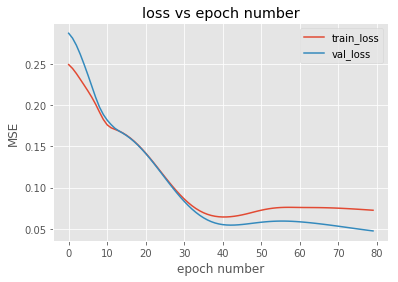

Loss: 

0.512138027553

Accuracy: 

0.4520766773162939

Loss: 

0.511903011221

Accuracy: 

0.4584664536741214

Loss: 

0.51155659755

Accuracy: 

0.4584664536741214

Loss: 

0.511104668757

Accuracy: 

0.46006389776357826

Loss: 

0.510555177828

Accuracy: 

0.46006389776357826

Loss: 

0.509917657113

Accuracy: 

0.46006389776357826

Loss: 

0.509201940124

Accuracy: 

0.46006389776357826

Loss: 

0.508416421746

Accuracy: 

0.46006389776357826

Loss: 

0.507566421243

Accuracy: 

0.4584664536741214

Loss: 

0.506653274043

Accuracy: 

0.46166134185303515

Loss: 

0.505674435678

Accuracy: 

0.46325878594249204

Loss: 

0.50462432013

Accuracy: 

0.46325878594249204

Loss: 

0.503495380513

Accuracy: 

0.46325878594249204

Loss: 

0.50227895222

Accuracy: 

0.46485623003194887

Loss: 

0.500965635169

Accuracy: 

0.46485623003194887

Loss: 

0.499545229169

Accuracy: 

0.46645367412140576

Loss: 

0.498006332446

Accuracy: 

0.46645367412140576

Loss: 

0.496335698302

Accuracy: 

0.4680511182108626

Loss: 

0.494517403679

Accuracy: 

0.4712460063897764

Loss: 

0.492531933228

Accuracy: 

0.4712460063897764

Loss: 

0.490355038228

Accuracy: 

0.4712460063897764

Loss: 

0.487956397324

Accuracy: 

0.4728434504792332

Loss: 

0.485297942555

Accuracy: 

0.4744408945686901

Loss: 

0.482331448503

Accuracy: 

0.4744408945686901

Loss: 

0.478994946978

Accuracy: 

0.476038338658147

Loss: 

0.475206777117

Accuracy: 

0.4792332268370607

Loss: 

0.470855180372

Accuracy: 

0.4840255591054313

Loss: 

0.465780619925

Accuracy: 

0.48881789137380194

Loss: 

0.45974670264

Accuracy: 

0.48722044728434505

Loss: 

0.452395757203

Accuracy: 

0.48562300319488816

Loss: 

0.443186399274

Accuracy: 

0.48722044728434505

Loss: 

0.431316230006

Accuracy: 

0.49201277955271566

Loss: 

0.415645958722

Accuracy: 

0.5031948881789138

Loss: 

0.394626693454

Accuracy: 

0.5159744408945687

Loss: 

0.365864584498

Accuracy: 

0.5383386581469649

Loss: 

0.323075765697

Accuracy: 

0.5846645367412141

Loss: 

0.250658735292

Accuracy: 

0.6517571884984026

Loss: 

0.161237173459

Accuracy: 

0.7843450479233227

Loss: 

0.118674899126

Accuracy: 

0.8498402555910544

Loss: 

0.109678586527

Accuracy: 

0.8706070287539937

Loss: 

0.107708263864

Accuracy: 

0.865814696485623

Loss: 

0.108671499892

Accuracy: 

0.8626198083067093

Loss: 

0.110923840173

Accuracy: 

0.8594249201277955

Loss: 

0.113743366277

Accuracy: 

0.8514376996805112

Loss: 

0.116782537284

Accuracy: 

0.8482428115015974

Loss: 

0.119897240385

Accuracy: 

0.8402555910543131

Loss: 

0.123066289639

Accuracy: 

0.8370607028753994

Loss: 

0.126258757377

Accuracy: 

0.8338658146964856

Loss: 

0.129377686402

Accuracy: 

0.829073482428115

Loss: 

0.132321542523

Accuracy: 

0.8210862619808307

Loss: 

0.135024255428

Accuracy: 

0.8210862619808307

Loss: 

0.137448440325

Accuracy: 

0.8178913738019169

Loss: 

0.139572528015

Accuracy: 

0.8115015974440895

Loss: 

0.141384185369

Accuracy: 

0.8099041533546326

Loss: 

0.142877976455

Accuracy: 

0.8099041533546326

Loss: 

0.144053875612

Accuracy: 

0.8099041533546326

Loss: 

0.144914623114

Accuracy: 

0.8099041533546326

Loss: 

0.145461676991

Accuracy: 

0.8130990415335463

Loss: 

0.145692172127

Accuracy: 

0.8099041533546326

Loss: 

0.145599880157

Accuracy: 

0.8130990415335463

Loss: 

0.145179350868

Accuracy: 

0.8115015974440895

Loss: 

0.144429868929

Accuracy: 

0.8130990415335463

Loss: 

0.143356906049

Accuracy: 

0.8178913738019169

Loss: 

0.141971462659

Accuracy: 

0.8178913738019169

Loss: 

0.14028865563

Accuracy: 

0.8178913738019169

Loss: 

0.138326546697

Accuracy: 

0.8226837060702875

Loss: 

0.136105686093

Accuracy: 

0.8258785942492013

Loss: 

0.133649319528

Accuracy: 

0.8274760383386581

Loss: 

0.130984122389

Accuracy: 

0.8322683706070287

Loss: 

0.128140829908

Accuracy: 

0.8354632587859425

Loss: 

0.125153838066

Accuracy: 

0.8354632587859425

Loss: 

0.122059076438

Accuracy: 

0.8434504792332268

Loss: 

0.118890571684

Accuracy: 

0.8450479233226837

Loss: 

0.115677994262

Accuracy: 

0.8498402555910544

Loss: 

0.112446987231

Accuracy: 

0.8562300319488818

Loss: 

0.109221704192

Accuracy: 

0.865814696485623

Loss: 

0.106026991571

Accuracy: 

0.865814696485623

Loss: 

0.102888458459

Accuracy: 

0.8722044728434505

Loss: 

0.0998305925756

Accuracy: 

0.8753993610223643

Loss: 

0.0968742500211

Accuracy: 

0.8785942492012779


Validation dataset evaluation:

Loss: 

0.0634374050177

Accuracy: 

0.9430379746835443

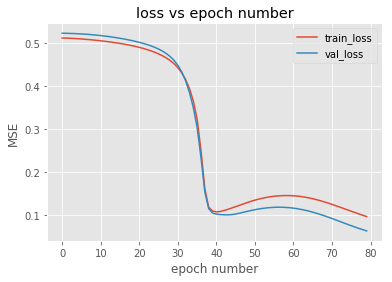

Loss: 

0.263359004191

Accuracy: 

0.5700636942675159

Loss: 

0.262211182144

Accuracy: 

0.5700636942675159

Loss: 

0.260498969508

Accuracy: 

0.5700636942675159

Loss: 

0.258222468192

Accuracy: 

0.5732484076433121

Loss: 

0.255382078369

Accuracy: 

0.5748407643312102

Loss: 

0.25197879073

Accuracy: 

0.5764331210191083

Loss: 

0.248014666248

Accuracy: 

0.5828025477707006

Loss: 

0.24349377546

Accuracy: 

0.5907643312101911

Loss: 

0.238424187341

Accuracy: 

0.5955414012738853

Loss: 

0.232822048598

Accuracy: 

0.6050955414012739

Loss: 

0.226718660737

Accuracy: 

0.6162420382165605

Loss: 

0.220169086982

Accuracy: 

0.6210191082802548

Loss: 

0.213255197019

Accuracy: 

0.6321656050955414

Loss: 

0.206074563397

Accuracy: 

0.6464968152866242

Loss: 

0.198721363477

Accuracy: 

0.660828025477707

Loss: 

0.19128023463

Accuracy: 

0.6703821656050956

Loss: 

0.183837088598

Accuracy: 

0.6894904458598726

Loss: 

0.176489165654

Accuracy: 

0.6990445859872612

Loss: 

0.169345755278

Accuracy: 

0.7181528662420382

Loss: 

0.162525865548

Accuracy: 

0.7420382165605095

Loss: 

0.156157381717

Accuracy: 

0.7340764331210191

Loss: 

0.150373905894

Accuracy: 

0.7372611464968153

Loss: 

0.145311808012

Accuracy: 

0.7579617834394905

Loss: 

0.141161258692

Accuracy: 

0.7691082802547771

Loss: 

0.138345566403

Accuracy: 

0.7866242038216561

Loss: 

0.137164492714

Accuracy: 

0.7834394904458599

Loss: 

0.136844137557

Accuracy: 

0.8009554140127388

Loss: 

0.136740708148

Accuracy: 

0.8057324840764332

Loss: 

0.136933451537

Accuracy: 

0.8152866242038217

Loss: 

0.137632971459

Accuracy: 

0.8296178343949044

Loss: 

0.13891265029

Accuracy: 

0.8359872611464968

Loss: 

0.140353720998

Accuracy: 

0.8407643312101911

Loss: 

0.141473601431

Accuracy: 

0.8439490445859873

Loss: 

0.142054716235

Accuracy: 

0.8439490445859873

Loss: 

0.14193704479

Accuracy: 

0.8439490445859873

Loss: 

0.140970057389

Accuracy: 

0.8439490445859873

Loss: 

0.13906366113

Accuracy: 

0.8423566878980892

Loss: 

0.136237183326

Accuracy: 

0.8455414012738853

Loss: 

0.132629481041

Accuracy: 

0.8471337579617835

Loss: 

0.128461399983

Accuracy: 

0.8471337579617835

Loss: 

0.123972158237

Accuracy: 

0.8519108280254777

Loss: 

0.119360612676

Accuracy: 

0.8519108280254777

Loss: 

0.114753603218

Accuracy: 

0.8550955414012739

Loss: 

0.110206872635

Accuracy: 

0.8535031847133758

Loss: 

0.10572439268

Accuracy: 

0.85828025477707

Loss: 

0.101278888713

Accuracy: 

0.8630573248407644

Loss: 

0.0968318795962

Accuracy: 

0.8662420382165605

Loss: 

0.0923894614327

Accuracy: 

0.8694267515923567

Loss: 

0.0881102969744

Accuracy: 

0.8837579617834395

Loss: 

0.0842353795833

Accuracy: 

0.893312101910828

Loss: 

0.0808197899064

Accuracy: 

0.8980891719745223

Loss: 

0.0778036534422

Accuracy: 

0.9012738853503185

Loss: 

0.075148783738

Accuracy: 

0.9124203821656051

Loss: 

0.0728266668077

Accuracy: 

0.9140127388535032

Loss: 

0.0708033991394

Accuracy: 

0.9171974522292994

Loss: 

0.0690401921644

Accuracy: 

0.9203821656050956

Loss: 

0.0674938240933

Accuracy: 

0.9219745222929936

Loss: 

0.0661127852445

Accuracy: 

0.9251592356687898

Loss: 

0.0648306270019

Accuracy: 

0.9251592356687898

Loss: 

0.0635605081221

Accuracy: 

0.9251592356687898

Loss: 

0.0622047131532

Accuracy: 

0.9235668789808917

Loss: 

0.0607123181583

Accuracy: 

0.9251592356687898

Loss: 

0.0591988576124

Accuracy: 

0.9251592356687898

Loss: 

0.0579558798115

Accuracy: 

0.928343949044586

Loss: 

0.0571508647316

Accuracy: 

0.9299363057324841

Loss: 

0.0566701699341

Accuracy: 

0.928343949044586

Loss: 

0.0563454523353

Accuracy: 

0.9267515923566879

Loss: 

0.0560879669284

Accuracy: 

0.928343949044586

Loss: 

0.0558642308573

Accuracy: 

0.9251592356687898

Loss: 

0.0556610008142

Accuracy: 

0.9251592356687898

Loss: 

0.0554711864692

Accuracy: 

0.9251592356687898

Loss: 

0.0552897582575

Accuracy: 

0.9267515923566879

Loss: 

0.0551127151937

Accuracy: 

0.9251592356687898

Loss: 

0.054936746872

Accuracy: 

0.9251592356687898

Loss: 

0.054759174949

Accuracy: 

0.9267515923566879

Loss: 

0.0545779501115

Accuracy: 

0.9267515923566879

Loss: 

0.0543916327775

Accuracy: 

0.9267515923566879

Loss: 

0.0541995753718

Accuracy: 

0.928343949044586

Loss: 

0.0540019122816

Accuracy: 

0.9299363057324841

Loss: 

0.05379963086

Accuracy: 

0.9299363057324841


Validation dataset evaluation:

Loss: 

0.0470715685885

Accuracy: 

0.9487179487179487

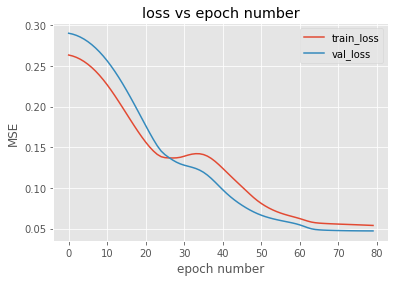

Loss: 

0.210652096793

Accuracy: 

0.5955414012738853

Loss: 

0.209593035461

Accuracy: 

0.5987261146496815

Loss: 

0.208023798733

Accuracy: 

0.6019108280254777

Loss: 

0.205960996229

Accuracy: 

0.606687898089172

Loss: 

0.203427273389

Accuracy: 

0.6114649681528662

Loss: 

0.200451496896

Accuracy: 

0.6194267515923567

Loss: 

0.197068762594

Accuracy: 

0.6305732484076433

Loss: 

0.193320654845

Accuracy: 

0.6369426751592356

Loss: 

0.189256628606

Accuracy: 

0.6401273885350318

Loss: 

0.184936121181

Accuracy: 

0.660828025477707

Loss: 

0.180427097596

Accuracy: 

0.6815286624203821

Loss: 

0.175794851214

Accuracy: 

0.6942675159235668

Loss: 

0.171083867573

Accuracy: 

0.7022292993630573

Loss: 

0.166309833992

Accuracy: 

0.7085987261146497

Loss: 

0.16147351269

Accuracy: 

0.7340764331210191

Loss: 

0.156583629442

Accuracy: 

0.7515923566878981

Loss: 

0.151668964543

Accuracy: 

0.7770700636942676

Loss: 

0.146775532148

Accuracy: 

0.7961783439490446

Loss: 

0.141956376995

Accuracy: 

0.8121019108280255

Loss: 

0.137260962228

Accuracy: 

0.8423566878980892

Loss: 

0.132727582371

Accuracy: 

0.8646496815286624

Loss: 

0.128379515777

Accuracy: 

0.8646496815286624

Loss: 

0.124224441754

Accuracy: 

0.8710191082802548

Loss: 

0.120257069625

Accuracy: 

0.8853503184713376

Loss: 

0.116463332613

Accuracy: 

0.8901273885350318

Loss: 

0.112825206635

Accuracy: 

0.893312101910828

Loss: 

0.109326072599

Accuracy: 

0.8949044585987261

Loss: 

0.105956445943

Accuracy: 

0.9012738853503185

Loss: 

0.102716715895

Accuracy: 

0.89171974522293

Loss: 

0.0996102534419

Accuracy: 

0.89171974522293

Loss: 

0.0966230201601

Accuracy: 

0.8901273885350318

Loss: 

0.0937054927886

Accuracy: 

0.89171974522293

Loss: 

0.090795875

Accuracy: 

0.89171974522293

Loss: 

0.0879112785369

Accuracy: 

0.89171974522293

Loss: 

0.0852316080709

Accuracy: 

0.89171974522293

Loss: 

0.0829596443354

Accuracy: 

0.8964968152866242

Loss: 

0.0810918917867

Accuracy: 

0.8964968152866242

Loss: 

0.0794976297637

Accuracy: 

0.893312101910828

Loss: 

0.0780670195779

Accuracy: 

0.893312101910828

Loss: 

0.0767278093958

Accuracy: 

0.8949044585987261

Loss: 

0.0754253039776

Accuracy: 

0.8964968152866242

Loss: 

0.0741100424441

Accuracy: 

0.8980891719745223

Loss: 

0.0727322109274

Accuracy: 

0.8980891719745223

Loss: 

0.0712428805365

Accuracy: 

0.8980891719745223

Loss: 

0.0696083610154

Accuracy: 

0.8964968152866242

Loss: 

0.0678466065199

Accuracy: 

0.8996815286624203

Loss: 

0.0660694230334

Accuracy: 

0.9044585987261147

Loss: 

0.0644521989757

Accuracy: 

0.9044585987261147

Loss: 

0.0630992294309

Accuracy: 

0.9044585987261147

Loss: 

0.0619726031798

Accuracy: 

0.9044585987261147

Loss: 

0.0609811337708

Accuracy: 

0.9060509554140127

Loss: 

0.0600614726233

Accuracy: 

0.9076433121019108

Loss: 

0.059185456908

Accuracy: 

0.9092356687898089

Loss: 

0.0583434142571

Accuracy: 

0.910828025477707

Loss: 

0.057532823179

Accuracy: 

0.9156050955414012

Loss: 

0.0567535502235

Accuracy: 

0.9171974522292994

Loss: 

0.0560061131577

Accuracy: 

0.9203821656050956

Loss: 

0.0552910666519

Accuracy: 

0.9203821656050956

Loss: 

0.0546089015739

Accuracy: 

0.9203821656050956

Loss: 

0.0539599970009

Accuracy: 

0.9219745222929936

Loss: 

0.0533445669038

Accuracy: 

0.9219745222929936

Loss: 

0.0527626845808

Accuracy: 

0.9219745222929936

Loss: 

0.052214188591

Accuracy: 

0.9251592356687898

Loss: 

0.051698696099

Accuracy: 

0.9267515923566879

Loss: 

0.0512156331445

Accuracy: 

0.9267515923566879

Loss: 

0.050764171902

Accuracy: 

0.928343949044586

Loss: 

0.0503432504786

Accuracy: 

0.928343949044586

Loss: 

0.0499516541291

Accuracy: 

0.928343949044586

Loss: 

0.0495880164629

Accuracy: 

0.928343949044586

Loss: 

0.0492508821144

Accuracy: 

0.928343949044586

Loss: 

0.0489387945907

Accuracy: 

0.9315286624203821

Loss: 

0.0486503033486

Accuracy: 

0.9331210191082803

Loss: 

0.0483840327517

Accuracy: 

0.9331210191082803

Loss: 

0.0481386883442

Accuracy: 

0.9331210191082803

Loss: 

0.0479131128059

Accuracy: 

0.9331210191082803

Loss: 

0.0477062635234

Accuracy: 

0.9315286624203821

Loss: 

0.0475172096916

Accuracy: 

0.9315286624203821

Loss: 

0.0473451419988

Accuracy: 

0.9299363057324841

Loss: 

0.0471893617455

Accuracy: 

0.9315286624203821

Loss: 

0.0470492501602

Accuracy: 

0.9331210191082803


Validation dataset evaluation:

Loss: 

0.0571446094137

Accuracy: 

0.9358974358974359

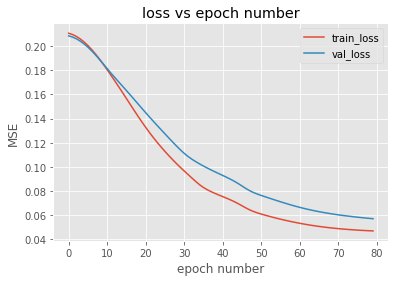

Loss: 

0.181881285736

Accuracy: 

0.6592356687898089

Loss: 

0.181091712116

Accuracy: 

0.6624203821656051

Loss: 

0.179917621968

Accuracy: 

0.6656050955414012

Loss: 

0.17836864207

Accuracy: 

0.6671974522292994

Loss: 

0.176458102214

Accuracy: 

0.6767515923566879

Loss: 

0.174203424986

Accuracy: 

0.6799363057324841

Loss: 

0.17162647531

Accuracy: 

0.6878980891719745

Loss: 

0.168753776069

Accuracy: 

0.6942675159235668

Loss: 

0.165616494468

Accuracy: 

0.7070063694267515

Loss: 

0.162250135804

Accuracy: 

0.714968152866242

Loss: 

0.15869388696

Accuracy: 

0.7308917197452229

Loss: 

0.154989612323

Accuracy: 

0.7468152866242038

Loss: 

0.151180561926

Accuracy: 

0.7611464968152867

Loss: 

0.147309919689

Accuracy: 

0.7707006369426752

Loss: 

0.143419398978

Accuracy: 

0.7770700636942676

Loss: 

0.13954800363

Accuracy: 

0.7866242038216561

Loss: 

0.135730722773

Accuracy: 

0.8057324840764332

Loss: 

0.131996150365

Accuracy: 

0.8136942675159236

Loss: 

0.128362026598

Accuracy: 

0.8343949044585988

Loss: 

0.124830416233

Accuracy: 

0.8503184713375797

Loss: 

0.121387440553

Accuracy: 

0.8598726114649682

Loss: 

0.118010850785

Accuracy: 

0.8662420382165605

Loss: 

0.114680212898

Accuracy: 

0.8710191082802548

Loss: 

0.111383310534

Accuracy: 

0.8805732484076433

Loss: 

0.108117139067

Accuracy: 

0.8869426751592356

Loss: 

0.10488578764

Accuracy: 

0.8885350318471338

Loss: 

0.101697703191

Accuracy: 

0.8901273885350318

Loss: 

0.098563748346

Accuracy: 

0.8980891719745223

Loss: 

0.0954966522427

Accuracy: 

0.9028662420382165

Loss: 

0.0925119233576

Accuracy: 

0.9044585987261147

Loss: 

0.089629587885

Accuracy: 

0.9076433121019108

Loss: 

0.0868741871471

Accuracy: 

0.9076433121019108

Loss: 

0.084270201196

Accuracy: 

0.9092356687898089

Loss: 

0.0818333656153

Accuracy: 

0.9092356687898089

Loss: 

0.0795657079174

Accuracy: 

0.910828025477707

Loss: 

0.0774589219019

Accuracy: 

0.9124203821656051

Loss: 

0.0755015887092

Accuracy: 

0.9124203821656051

Loss: 

0.0736836299358

Accuracy: 

0.9156050955414012

Loss: 

0.0719968593802

Accuracy: 

0.9156050955414012

Loss: 

0.0704339318546

Accuracy: 

0.9171974522292994

Loss: 

0.0689872151526

Accuracy: 

0.9187898089171974

Loss: 

0.0676484627896

Accuracy: 

0.9219745222929936

Loss: 

0.0664089976902

Accuracy: 

0.9235668789808917

Loss: 

0.0652600695574

Accuracy: 

0.9235668789808917

Loss: 

0.064193338484

Accuracy: 

0.9251592356687898

Loss: 

0.0632011818504

Accuracy: 

0.9267515923566879

Loss: 

0.0622767908129

Accuracy: 

0.9267515923566879

Loss: 

0.0614141797771

Accuracy: 

0.9267515923566879

Loss: 

0.0606079555261

Accuracy: 

0.928343949044586

Loss: 

0.0598533089572

Accuracy: 

0.928343949044586

Loss: 

0.0591458795764

Accuracy: 

0.9299363057324841

Loss: 

0.0584816196348

Accuracy: 

0.9315286624203821

Loss: 

0.0578566841055

Accuracy: 

0.9331210191082803

Loss: 

0.0572673040019

Accuracy: 

0.9331210191082803

Loss: 

0.056709678398

Accuracy: 

0.9347133757961783

Loss: 

0.0561798222346

Accuracy: 

0.9378980891719745

Loss: 

0.0556732761857

Accuracy: 

0.9378980891719745

Loss: 

0.0551848003881

Accuracy: 

0.9378980891719745

Loss: 

0.0547079897903

Accuracy: 

0.9363057324840764

Loss: 

0.0542347299068

Accuracy: 

0.9363057324840764

Loss: 

0.0537545645359

Accuracy: 

0.9363057324840764

Loss: 

0.0532542468776

Accuracy: 

0.9378980891719745

Loss: 

0.0527178437476

Accuracy: 

0.9378980891719745

Loss: 

0.0521288111692

Accuracy: 

0.9378980891719745

Loss: 

0.05147618475

Accuracy: 

0.9378980891719745

Loss: 

0.0507666262323

Accuracy: 

0.9394904458598726

Loss: 

0.0500382340419

Accuracy: 

0.9394904458598726

Loss: 

0.0493583498555

Accuracy: 

0.9426751592356688

Loss: 

0.0487893870939

Accuracy: 

0.9426751592356688

Loss: 

0.0483486957267

Accuracy: 

0.9426751592356688

Loss: 

0.0480092443293

Accuracy: 

0.9426751592356688

Loss: 

0.0477319163661

Accuracy: 

0.9426751592356688

Loss: 

0.047487919634

Accuracy: 

0.9426751592356688

Loss: 

0.0472615381385

Accuracy: 

0.9426751592356688

Loss: 

0.0470452808827

Accuracy: 

0.9442675159235668

Loss: 

0.0468355830453

Accuracy: 

0.9442675159235668

Loss: 

0.0466305195315

Accuracy: 

0.9442675159235668

Loss: 

0.0464288252433

Accuracy: 

0.9442675159235668

Loss: 

0.0462295337518

Accuracy: 

0.9442675159235668

Loss: 

0.0460318788773

Accuracy: 

0.9426751592356688


Validation dataset evaluation:

Loss: 

0.0903962978963

Accuracy: 

0.8910256410256411

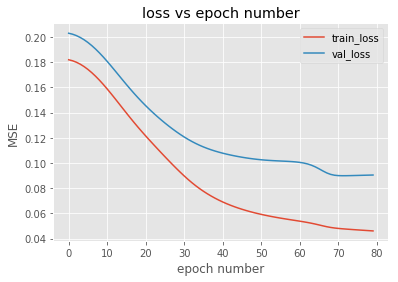

In [30]:

#Create array with only bad transactions
fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
fraud_indices = dataset.iloc[fraud_indices, :].sample(frac=1)
fraud_indices = fraud_indices.values
# k-fold validation with k=5
k_fold_split_array = k_fold_split_data(fraud_indices, 5)
models = []
for n, validation in enumerate(k_fold_split_array):
    #print(k_fold_split_array)
    #losowanie dobrych tranzakcji
    random_normal_indices = get_radnom_normal_indices(dataset,train_and_validation)
    random_normal_indices = random_normal_indices.values

    normal_indices_split_array = k_fold_split_data(random_normal_indices, 5)
    validation_normal_indices = normal_indices_split_array.pop(n)
    normal_indices_split_array = np.concatenate(normal_indices_split_array)

    train = k_fold_split_array.copy()
    train.pop(n)
    train = np.concatenate(train)
    train = np.concatenate([train,normal_indices_split_array])
    np.random.shuffle(train)

    x_train = train[:, :-1]
    y_train = train[:, -1:]

    validation = np.concatenate([validation,validation_normal_indices])
    np.random.shuffle(validation)

    x_validation = validation[:, :-1]
    y_validation = validation[:, -1:]

        # 653
    model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
    model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
    model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
    model.fit(x_train, y_train, x_validation, y_validation)

    print("\n", '='*80)
    print("\nValidation dataset evaluation:")
    model.evaluate(x_validation, y_validation)
    print("\n")
    plot_loss(model.epochs, model.training_history, model.validation_history)
    models.append(model)

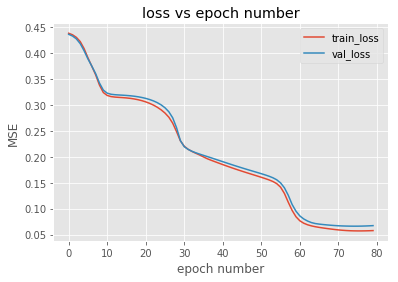

In [13]:
training_history = np.average([mdl.training_history for mdl in models], axis=0)
validation_history = np.average([mdl.validation_history for mdl in models], axis=0)

plot_loss(EPOCHS, training_history, validation_history)


# EVALUATION ON TEST DATASET

In [32]:
print("\nTest dataset evaluation:")
x_train_and_validation = under_sample_dataset[:, :-1]
y_train_and_validation = under_sample_dataset[:, -1:]

test_model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train_and_validation.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
test_model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
test_model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
test_model.fit(x_train_and_validation, y_train_and_validation)



Test dataset evaluation:

Loss: 

0.217733649196

Accuracy: 

0.5854591836734694

Loss: 

0.216936321842

Accuracy: 

0.5892857142857143

Loss: 

0.215749892432

Accuracy: 

0.5931122448979592

Loss: 

0.214178013113

Accuracy: 

0.5969387755102041

Loss: 

0.212225724998

Accuracy: 

0.6007653061224489

Loss: 

0.209899656415

Accuracy: 

0.6020408163265306

Loss: 

0.207208268231

Accuracy: 

0.610969387755102

Loss: 

0.204162132515

Accuracy: 

0.6160714285714286

Loss: 

0.200774244463

Accuracy: 

0.6147959183673469

Loss: 

0.197060329782

Accuracy: 

0.6211734693877551

Loss: 

0.193039154345

Accuracy: 

0.6262755102040817

Loss: 

0.188732744025

Accuracy: 

0.6403061224489796

Loss: 

0.184166512666

Accuracy: 

0.6517857142857143

Loss: 

0.179369228107

Accuracy: 

0.6683673469387755

Loss: 

0.174372800889

Accuracy: 

0.673469387755102

Loss: 

0.16921192575

Accuracy: 

0.6798469387755102

Loss: 

0.163923599515

Accuracy: 

0.6989795918367347

Loss: 

0.158546584754

Accuracy: 

0.7219387755102041

Loss: 

0.153120904542

Accuracy: 

0.7423469387755102

Loss: 

0.147687396235

Accuracy: 

0.7551020408163265

Loss: 

0.142287249299

Accuracy: 

0.7691326530612245

Loss: 

0.136961435947

Accuracy: 

0.7933673469387755

Loss: 

0.131749908041

Accuracy: 

0.8188775510204082

Loss: 

0.126690680811

Accuracy: 

0.8456632653061225

Loss: 

0.121818686818

Accuracy: 

0.860969387755102

Loss: 

0.11716478601

Accuracy: 

0.8737244897959183

Loss: 

0.112754787119

Accuracy: 

0.8877551020408163

Loss: 

0.108608347159

Accuracy: 

0.8915816326530612

Loss: 

0.104738012555

Accuracy: 

0.8992346938775511

Loss: 

0.101147701476

Accuracy: 

0.9005102040816326

Loss: 

0.097833161103

Accuracy: 

0.9005102040816326

Loss: 

0.0947834305742

Accuracy: 

0.8992346938775511

Loss: 

0.0919833437127

Accuracy: 

0.9030612244897959

Loss: 

0.0894155552828

Accuracy: 

0.9043367346938775

Loss: 

0.0870614809808

Accuracy: 

0.9043367346938775

Loss: 

0.0849008588211

Accuracy: 

0.9030612244897959

Loss: 

0.0829102680283

Accuracy: 

0.9094387755102041

Loss: 

0.0810614509405

Accuracy: 

0.9068877551020408

Loss: 

0.0793195648402

Accuracy: 

0.9068877551020408

Loss: 

0.0776423668789

Accuracy: 

0.9056122448979592

Loss: 

0.0759824352316

Accuracy: 

0.9056122448979592

Loss: 

0.0742974210501

Accuracy: 

0.9056122448979592

Loss: 

0.0725757539844

Accuracy: 

0.9068877551020408

Loss: 

0.0708738525046

Accuracy: 

0.9094387755102041

Loss: 

0.0693209719959

Accuracy: 

0.9145408163265306

Loss: 

0.0680373277754

Accuracy: 

0.9145408163265306

Loss: 

0.067036800038

Accuracy: 

0.9158163265306123

Loss: 

0.0662457905184

Accuracy: 

0.9132653061224489

Loss: 

0.0655848700998

Accuracy: 

0.9145408163265306

Loss: 

0.0650047056932

Accuracy: 

0.9132653061224489

Loss: 

0.0644799168374

Accuracy: 

0.9145408163265306

Loss: 

0.0639966141939

Accuracy: 

0.9145408163265306

Loss: 

0.063545492209

Accuracy: 

0.9145408163265306

Loss: 

0.063119222081

Accuracy: 

0.9145408163265306

Loss: 

0.0627116213125

Accuracy: 

0.9158163265306123

Loss: 

0.062317429423

Accuracy: 

0.9158163265306123

Loss: 

0.0619323338657

Accuracy: 

0.9170918367346939

Loss: 

0.0615528928647

Accuracy: 

0.9170918367346939

Loss: 

0.0611765251473

Accuracy: 

0.9196428571428571

Loss: 

0.0608014722175

Accuracy: 

0.9209183673469388

Loss: 

0.0604267120998

Accuracy: 

0.9221938775510204

Loss: 

0.0600518535818

Accuracy: 

0.9209183673469388

Loss: 

0.0596770594108

Accuracy: 

0.9209183673469388

Loss: 

0.0593029159388

Accuracy: 

0.9209183673469388

Loss: 

0.0589302932796

Accuracy: 

0.9221938775510204

Loss: 

0.0585602638975

Accuracy: 

0.9221938775510204

Loss: 

0.0581940069029

Accuracy: 

0.923469387755102

Loss: 

0.0578327089882

Accuracy: 

0.923469387755102

Loss: 

0.0574775165387

Accuracy: 

0.923469387755102

Loss: 

0.0571294923135

Accuracy: 

0.923469387755102

Loss: 

0.0567895778475

Accuracy: 

0.9260204081632653

Loss: 

0.0564585743995

Accuracy: 

0.9260204081632653

Loss: 

0.0561371499435

Accuracy: 

0.9260204081632653

Loss: 

0.0558258522424

Accuracy: 

0.9260204081632653

Loss: 

0.0555251552809

Accuracy: 

0.9247448979591837

Loss: 

0.0552353838668

Accuracy: 

0.9247448979591837

Loss: 

0.0549567761072

Accuracy: 

0.9247448979591837

Loss: 

0.0546894908153

Accuracy: 

0.9247448979591837

Loss: 

0.054433609674

Accuracy: 

0.9272959183673469

Loss: 

0.0541891484833

Accuracy: 

0.9272959183673469

In [33]:
test_model.evaluate(x_test, y_test)
plot_confusion_matrix(model, x_test, y_test)
# print(model.layers[0].weights)

Loss: 

0.0135681554627

Accuracy: 

0.9890804395913065


Precision: 0.09843400447427293

Recall: 0.88

F-score: 0.17706237424547283

             actual 1  actual 0
predicted 1        88       806
predicted 0        12     56056

  0%|                                                   | 0/21 [00:00<?, ?it/s]

  5%|██                                         | 1/21 [00:05<01:56,  5.81s/it]

 10%|████                                       | 2/21 [00:10<01:35,  5.02s/it]

 14%|██████▏                                    | 3/21 [00:14<01:25,  4.73s/it]

 19%|████████▏                                  | 4/21 [00:18<01:17,  4.58s/it]

 24%|██████████▏                                | 5/21 [00:22<01:11,  4.50s/it]

 29%|████████████▎                              | 6/21 [00:27<01:08,  4.56s/it]

 33%|██████████████▎                            | 7/21 [00:35<01:10,  5.00s/it]

 38%|████████████████▍                          | 8/21 [00:40<01:05,  5.06s/it]

 43%|██████████████████▍                        | 9/21 [00:44<00:59,  4.99s/it]

 48%|████████████████████                      | 10/21 [00:49<00:54,  4.91s/it]

 52%|██████████████████████                    | 11/21 [00:53<00:48,  4.83s/it]

 57%|████████████████████████                  | 12/21 [00:57<00:42,  4.76s/it]

 62%|██████████████████████████                | 13/21 [01:01<00:37,  4.72s/it]

 67%|████████████████████████████              | 14/21 [01:05<00:32,  4.68s/it]

 71%|██████████████████████████████            | 15/21 [01:09<00:27,  4.64s/it]

 76%|████████████████████████████████          | 16/21 [01:13<00:23,  4.61s/it]

 81%|██████████████████████████████████        | 17/21 [01:18<00:18,  4.60s/it]

 86%|████████████████████████████████████      | 18/21 [01:22<00:13,  4.59s/it]

 90%|██████████████████████████████████████    | 19/21 [01:29<00:09,  4.73s/it]

 95%|████████████████████████████████████████  | 20/21 [01:43<00:05,  5.19s/it]

100%|██████████████████████████████████████████| 21/21 [01:48<00:00,  5.19s/it]

No handles with labels found to put in legend.

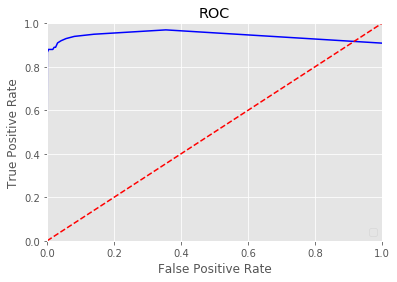

In [34]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    predicted = np.round(model.predict(x_test) + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)

In [35]:
plot_ROC(TPR_array, FPR_array, [0.001, 0.01, 0.1, 1, 100], 'C', 1)

TypeError: plot_ROC() takes 2 positional arguments but 5 were given